In [2]:
import datajoint as dj

dj.config['database.host'] = "gl-ash.biostr.washington.edu"
dj.config['database.user'] = "molly"
dj.config['database.port'] = 3306

from spyglass.utils.nwb_helper_fn import get_nwb_file
from spyglass.common.common_behav import StateScriptFile
from spyglass.common.common_task import TaskEpoch
from spyglass.common.common_nwbfile import AnalysisNwbfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from trials import TrialInfo
from utils.parse_trials_helper import V8TrialParser

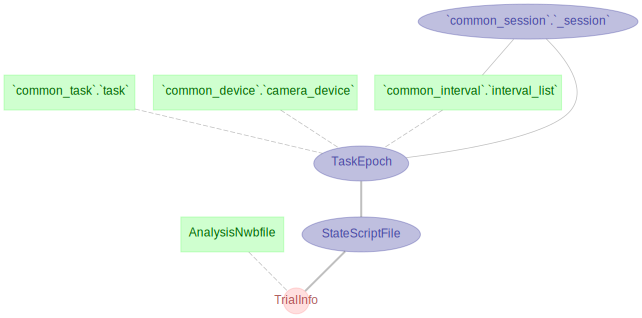

In [3]:
dj.Diagram(TaskEpoch) + dj.Diagram(TrialInfo) - 1

In [4]:
TrialInfo.heading

# 
nwb_file_name        : varchar(64)                  # name of the NWB file
epoch                : int                          # the session epoch for this task and apparatus(1 based)
---
analysis_file_name   : varchar(64)                  # name of the file
trial_info_object_id : varchar(40)                  # the NWB object ID for loading this object from the file
parser               : varchar(100)                 # type of parser used to interpret statescript log
descriptors=null     : blob                         # global descriptors for task

## Testing insert of a single epoch:
Normally this would be auto populated from each entry in StateScriptFile, but for now we can test inserting a single epoch

In [5]:
key = (StateScriptFile & {'nwb_file_name' : 'bobrick20231114_.nwb', 'epoch':4}).fetch1() # example of a StateScriptFile primary key
key

{'nwb_file_name': 'bobrick20231114_.nwb',
 'epoch': 4,
 'file_object_id': 'bbfa4352-be80-4870-9951-21273a1be35d'}

In [19]:
TrialInfo.populate(key)

bug trial #9, epoch 4! line 267: index 0 is out of bounds for axis 0 with size 0
bug trial #10, epoch 4! line 299: 
bug trial #21, epoch 4! line 267: index 0 is out of bounds for axis 0 with size 0
bug trial #22, epoch 4! line 299: 


[14:05:35][INFO] Spyglass: Writing new NWB file bobrick20231114_OZFNY00L80.nwb


In [6]:
TrialInfo()

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),analysis_file_name name of the file,trial_info_object_id the NWB object ID for loading this object from the file,parser type of parser used to interpret statescript log,descriptors global descriptors for task


In [7]:
# The resulting entry in AnalysisNwbfile that was generated
(AnalysisNwbfile & {"nwb_file_name" : "bobrick20231114_.nwb"})

analysis_file_name name of the file,nwb_file_name name of the NWB file,analysis_file_abs_path the full path to the file,analysis_file_description an optional description of this analysis,analysis_parameters additional relevant parameters. Currently used only for analyses


## Reading the resulting analysis file

In [8]:
# from pynwb import NWBHDF5IO
# filename = "bobrick20231204_V8CPDSZ13B.nwb"
# filepath = filepath = (AnalysisNwbfile & {"analysis_file_name" : filename}).fetch1("analysis_file_abs_path")
# io = NWBHDF5IO(filepath, mode="r")
# nwbfile = io.read()

filename = (TrialInfo & key).fetch1("analysis_file_name")
obj_id = (TrialInfo & key).fetch1("trial_info_object_id")
filepath = (AnalysisNwbfile & {"analysis_file_name" : filename}).fetch1("analysis_file_abs_path")
nwbfile = get_nwb_file(filepath)
trials_df = nwbfile.objects[obj_id]
trials_df

,start_time,end_time,lockout_starts,lockout_ends,during_lockout,lockout_type,rw_start,rw_end,leave_home,leave_rw,trial_type,outer_well,outer_time,leave_outer,outer_success,goal_well,rw_success
id,,,,,,,,,,,,,,,,,
1,1.699993e+09,1.699993e+09,[],[],[],0.0,1.699993e+09,1.699993e+09,1.699993e+09,1.699993e+09,2.0,5,1.699993e+09,1.699993e+09,0.0,9.0,1.0
2,1.699993e+09,1.699993e+09,[],[],[],0.0,1.699993e+09,1.699993e+09,1.699993e+09,1.699993e+09,1.0,8,1.699993e+09,1.699993e+09,0.0,9.0,1.0
3,1.699993e+09,1.699993e+09,[],[],[],0.0,1.699993e+09,1.699993e+09,1.699993e+09,1.699993e+09,2.0,6,1.699993e+09,1.699993e+09,0.0,9.0,1.0
4,1.699993e+09,1.699993e+09,[1699993381.5339506],[1699993411.5339506],[10],1.0,1.699993e+09,1.699993e+09,1.699993e+09,1.699993e+09,2.0,0,0.000000e+00,0.000000e+00,0.0,9.0,1.0


In [13]:
# option: run this cell to get an interactive plot (only works in jupyter, not vscode)
%matplotlib notebook

Using matplotlib backend: <object object at 0x7faab38e17d0>


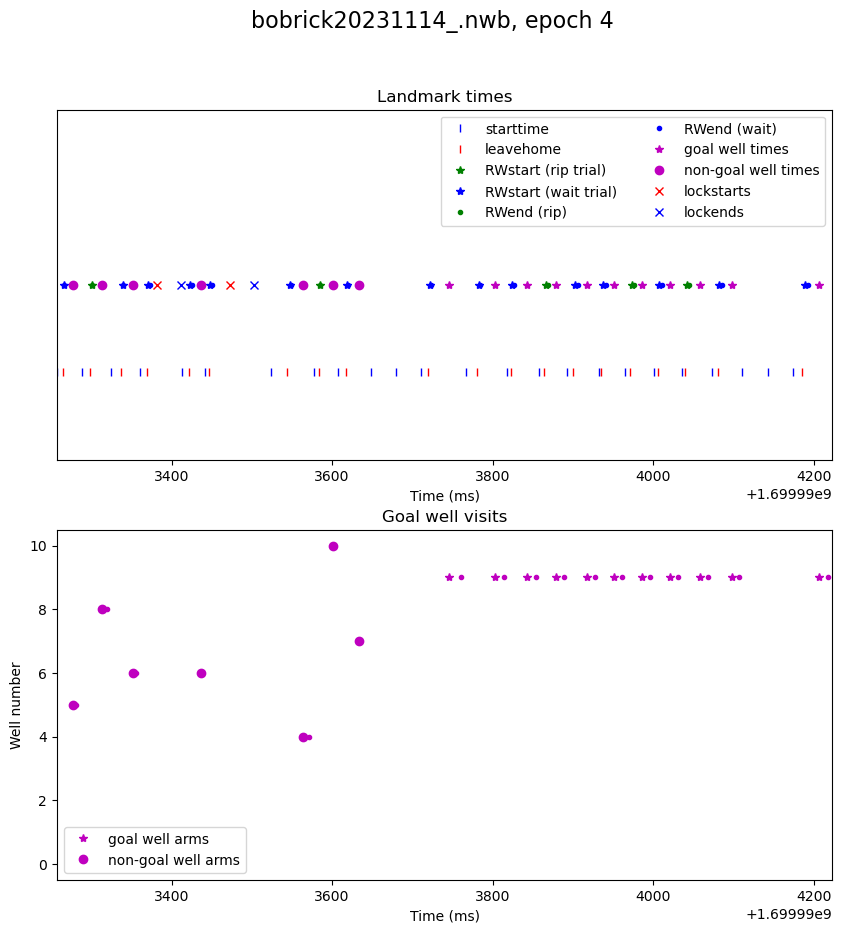

In [17]:
V8TrialParser.plot_trials(trials_df, key)

## Cleanup
* Deletes analysis file from the AnalysisNwbfile table, which automatically removes the corresponding entry in the TrialsInfo table
* Deletes analysis file from banyan

In [6]:
# AnalysisNwbfile is upstream, so this should automatically delete the entry in TrialsInfo that generated it?
(AnalysisNwbfile & {"nwb_file_name" : "bobrick20231114_.nwb"}).delete()

[14:52:46][INFO] Spyglass: Building merge cache for analysis_nwbfile.
	Found 2 downstream merge tables
[2024-03-14 14:52:46,802][INFO]: Deleting 2 rows from `TrialsInfo`.`__trials_info`
[2024-03-14 14:52:46,814][INFO]: Deleting 2 rows from `common_nwbfile`.`analysis_nwbfile`
[2024-03-14 14:52:49,797][INFO]: Deletes committed.


In [7]:
# ah, this proves the above is correct
TrialInfo & {"nwb_file_name" : "bobrick20231114_.nwb"}

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),analysis_file_name name of the file,trial_info_object_id file object id pointing to trial analysis,parser type of parser used to interpret statescript log,descriptors global descriptors for task


In [8]:
# i think this deletes the files from the computer but not the actual AnalysisNwbfile table.
# an extra merge cache file is generated, but this seems to disappear after a few hours
AnalysisNwbfile.cleanup(delete_files=True)

100%|██████████| 2/2 [00:00<00:00, 15.78it/s]


### IGNORE! various commands for testing how other tables store analysis files

In [9]:
AnalysisNwbfile.heading

# Table for holding the NWB files that contain results of analysis, such as spike sorting.
analysis_file_name   : varchar(64)                  # name of the file
---
nwb_file_name        : varchar(64)                  # name of the NWB file
analysis_file_abs_path : filepath@analysis            # the full path to the file
analysis_file_description="" : varchar(2000)                # an optional description of this analysis
analysis_parameters=null : blob                         # additional relevant parameters. Currently used only for analyses

In [10]:
AnalysisNwbfile & {"nwb_file_name" : "bobrick20231204_.nwb"}

analysis_file_name name of the file,nwb_file_name name of the NWB file,analysis_file_abs_path the full path to the file,analysis_file_description an optional description of this analysis,analysis_parameters additional relevant parameters. Currently used only for analyses
bobrick20231204_0OMGF0WIFM.nwb,bobrick20231204_.nwb,=BLOB=,,=BLOB=
bobrick20231204_0WS5VGASPK.nwb,bobrick20231204_.nwb,=BLOB=,,=BLOB=
bobrick20231204_32R2ZELDNO.nwb,bobrick20231204_.nwb,=BLOB=,,=BLOB=
bobrick20231204_3JDRDI1ZG8.nwb,bobrick20231204_.nwb,=BLOB=,,=BLOB=
bobrick20231204_5C2WTQ5QSH.nwb,bobrick20231204_.nwb,=BLOB=,,=BLOB=
bobrick20231204_5N02JUQD5Z.nwb,bobrick20231204_.nwb,=BLOB=,,=BLOB=
bobrick20231204_78P1KOGWS7.nwb,bobrick20231204_.nwb,=BLOB=,,=BLOB=
bobrick20231204_81S3YI2NC9.nwb,bobrick20231204_.nwb,=BLOB=,,=BLOB=
bobrick20231204_8IPNUUQIV0.nwb,bobrick20231204_.nwb,=BLOB=,,=BLOB=
bobrick20231204_A5Z36PKZQB.nwb,bobrick20231204_.nwb,=BLOB=,,=BLOB=


In [11]:
import spyglass.lfp.v1 as sgl
# example 1: LFPV1 contains foreign key ref to AnalysisNwbfile
sgl.LFPV1.heading

nwb_file_name        : varchar(64)                  # name of the NWB file
lfp_electrode_group_name : varchar(30)                  # the name of this group of electrodes
target_interval_list_name : varchar(170)                 # descriptive name of this interval list
filter_name          : varchar(80)                  # descriptive name of this filter
filter_sampling_rate : int                          # sampling rate for this filter
---
analysis_file_name   : varchar(64)                  # name of the file
interval_list_name   : varchar(170)                 # descriptive name of this interval list
lfp_object_id        : varchar(40)                  # the NWB object ID for loading this object from the file
lfp_sampling_rate    : float                        # the sampling rate, in HZ

In [12]:
sgl.LFPV1 & {"nwb_file_name" : "bobrick20231204_.nwb"}

nwb_file_name name of the NWB file,lfp_electrode_group_name the name of this group of electrodes,target_interval_list_name descriptive name of this interval list,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,analysis_file_name name of the file,interval_list_name descriptive name of this interval list,lfp_object_id the NWB object ID for loading this object from the file,"lfp_sampling_rate the sampling rate, in HZ"
bobrick20231204_.nwb,all_labeled_tet_chans,02_r1,LFP 0-400 Hz,30000,bobrick20231204_V8CPDSZ13B.nwb,lfp_all_labeled_tet_chans_02_r1_valid times,3ba13d7e-d112-49d5-be70-9ffb8259873c,1000.0


In [13]:
from pynwb import NWBHDF5IO

# entry contains the filename and object id
lfp_key = (sgl.LFPV1 & {"nwb_file_name" : "bobrick20231204_.nwb"}).fetch1()
filename = lfp_key["analysis_file_name"]
obj_id = lfp_key["lfp_object_id"]

# use filename as a foreign key to the entry in AnalysisNwbfile, where we can retrieve the file path
filepath = (AnalysisNwbfile & {"analysis_file_name" : filename}).fetch1("analysis_file_abs_path")

# open the file at the given path and retrieve the object of intereste via object id
io = NWBHDF5IO(filepath, mode="r")
nwbfile = io.read()
lfp_obj = nwbfile.objects[obj_id]
# print(np.asarray(lfp_obj.timestamps))
# print(np.asarray(lfp_obj.data))
lfp_obj

,location,group,group_name,x,y,z,imp,filtering,rel_x,rel_y,rel_z,hwChan,ntrode_id,channel_id,bad_channel,probe_shank,probe_electrode,ref_elect_id
id,,,,,,,,,,,,,,,,,,
0,Cornu ammonis 1 (CA1),0 abc.NwbElectrodeGroup at 0x140572418903872\nFields:\n description: tetrode\n device: probe 0 abc.Probe at 0x140572419094176\nFields:\n contact_side_numbering: True\n contact_size: 12.5\n id: 0\n probe_description: four wire electrode\n probe_type: tetrode_12.5\n shanks: {\n 0 <class 'abc.Shank'>\n }\n units: um\n\n location: ca1\n targeted_location: Cornu ammonis 1 (CA1)\n targeted_x: 0.0\n targeted_y: 0.0\n targeted_z: 0.0\n units: μm\n,0,0.0,0.0,0.0,0.0,None,6.25,0.0,6.25,193,1,0,False,0,0,16
1,Cornu ammonis 1 (CA1),0 abc.NwbElectrodeGroup at 0x140572418903872\nFields:\n description: tetrode\n device: probe 0 abc.Probe at 0x140572419094176\nFields:\n contact_side_numbering: True\n contact_size: 12.5\n id: 0\n probe_description: four wire electrode\n probe_type: tetrode_12.5\n shanks: {\n 0 <class 'abc.Shank'>\n }\n units: um\n\n location: ca1\n targeted_location: Cornu ammonis 1 (CA1)\n targeted_x: 0.0\n targeted_y: 0.0\n targeted_z: 0.0\n units: μm\n,0,0.0,0.0,0.0,0.0,None,-6.25,0.0,6.25,195,1,1,False,0,1,16
2,Cornu ammonis 1 (CA1),0 abc.NwbElectrodeGroup at 0x140572418903872\nFields:\n description: tetrode\n device: probe 0 abc.Probe at 0x140572419094176\nFields:\n contact_side_numbering: True\n contact_size: 12.5\n id: 0\n probe_description: four wire electrode\n probe_type: tetrode_12.5\n shanks: {\n 0 <class 'abc.Shank'>\n }\n units: um\n\n location: ca1\n targeted_location: Cornu ammonis 1 (CA1)\n targeted_x: 0.0\n targeted_y: 0.0\n targeted_z: 0.0\n units: μm\n,0,0.0,0.0,0.0,0.0,None,-6.25,0.0,-6.25,197,1,2,False,0,2,16
3,Cornu ammonis 1 (CA1),0 abc.NwbElectrodeGroup at 0x140572418903872\nFields:\n description: tetrode\n device: probe 0 abc.Probe at 0x140572419094176\nFields:\n contact_side_numbering: True\n contact_size: 12.5\n id: 0\n probe_description: four wire electrode\n probe_type: tetrode_12.5\n shanks: {\n 0 <class 'abc.Shank'>\n }\n units: um\n\n location: ca1\n targeted_location: Cornu ammonis 1 (CA1)\n targeted_x: 0.0\n targeted_y: 0.0\n targeted_z: 0.0\n units: μm\n,0,0.0,0.0,0.0,0.0,None,6.25,0.0,-6.25,199,1,3,False,0,3,16


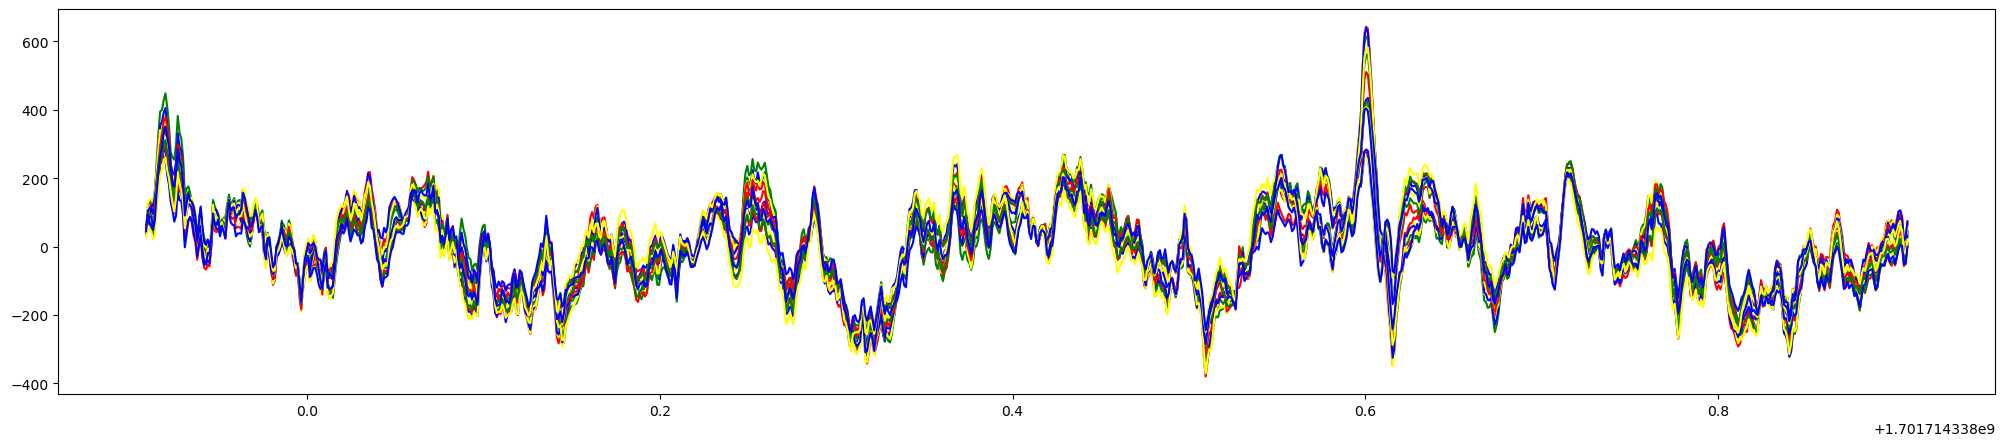

In [14]:
times = np.asarray(lfp_obj.timestamps)[:1000]
data = np.asarray(lfp_obj.data).transpose()[:, :1000]
colors = ['red', 'green', 'yellow', 'blue']
plt.figure(figsize=(25,5))
for i in range(16):
    plt.plot(times, data[i], color=colors[i % 4])
# plt.plot(np.asarray(lfp_obj.timestamps), np.asarray(lfp_obj.data))
# plt.show()

In [15]:
import spyglass.spikesorting.v0 as sgs

# example 2: SpikeSorting contains a file reference to a NON-nwb file. entries directly hold the file path.
sgs.SpikeSorting.heading

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


nwb_file_name        : varchar(64)                  # name of the NWB file
sort_group_id        : int                          # identifier for a group of electrodes
sort_interval_name   : varchar(64)                  # name for this interval
preproc_params_name  : varchar(32)                  # 
team_name            : varchar(80)                  # 
sorter               : varchar(32)                  # 
sorter_params_name   : varchar(64)                  # 
artifact_removed_interval_list_name : varchar(170)                 # 
---
sorting_path         : varchar(1000)                # 
time_of_sort         : int                          # in Unix time, to the nearest second

In [16]:
# file can be retrieved by directly using the path in the entry without using foreign key refs
(sgs.SpikeSorting & {"nwb_file_name" : "bobrick20231204_.nwb"})

nwb_file_name name of the NWB file,sort_group_id identifier for a group of electrodes,sort_interval_name name for this interval,preproc_params_name,team_name,sorter,sorter_params_name,artifact_removed_interval_list_name,sorting_path,"time_of_sort in Unix time, to the nearest second"
bobrick20231204_.nwb,0,02_r1_first300,default_hippocampus,My Team,mountainsort4,hippocampus_tutorial,bobrick20231204_.nwb_02_r1_first300_0_default_hippocampus_none_artifact_removed_valid_times,/home/gl-willow/banyan/nwb/sorting/bobrick20231204_.nwb_02_r1_first300_0_default_hippocampus_7a922c65_spikesorting,1709859006
bobrick20231204_.nwb,0,02_r1_first4000,default_hippocampus,My Team,mountainsort4,hippocampus_tutorial,bobrick20231204_.nwb_02_r1_first4000_0_default_hippocampus_none_artifact_removed_valid_times,/home/gl-willow/banyan/nwb/sorting/bobrick20231204_.nwb_02_r1_first4000_0_default_hippocampus_c0a1ac82_spikesorting,1709876154
bobrick20231204_.nwb,1,02_r1_first30,default_hippocampus,My Team,mountainsort4,hippocampus_tutorial,bobrick20231204_.nwb_02_r1_first30_1_default_hippocampus_none_artifact_removed_valid_times,/home/gl-willow/banyan/nwb/sorting/bobrick20231204_.nwb_02_r1_first30_1_default_hippocampus_e36c2ad9_spikesorting,1709869832
bobrick20231204_.nwb,1,02_r1_first4000,default_hippocampus,My Team,mountainsort4,hippocampus_tutorial,bobrick20231204_.nwb_02_r1_first4000_1_default_hippocampus_none_artifact_removed_valid_times,/home/gl-willow/banyan/nwb/sorting/bobrick20231204_.nwb_02_r1_first4000_1_default_hippocampus_fc7f5b73_spikesorting,1709873411
bobrick20231204_.nwb,2,02_r1_first30,default_hippocampus,My Team,mountainsort4,hippocampus_tutorial,bobrick20231204_.nwb_02_r1_first30_2_default_hippocampus_none_artifact_removed_valid_times,/home/gl-willow/banyan/nwb/sorting/bobrick20231204_.nwb_02_r1_first30_2_default_hippocampus_fd31b7c3_spikesorting,1709869825
bobrick20231204_.nwb,2,02_r1_first4000,default_hippocampus,My Team,mountainsort4,hippocampus_tutorial,bobrick20231204_.nwb_02_r1_first4000_2_default_hippocampus_none_artifact_removed_valid_times,/home/gl-willow/banyan/nwb/sorting/bobrick20231204_.nwb_02_r1_first4000_2_default_hippocampus_170f2449_spikesorting,1709873152
bobrick20231204_.nwb,3,02_r1_first4000,default_hippocampus,My Team,mountainsort4,hippocampus_tutorial,bobrick20231204_.nwb_02_r1_first4000_3_default_hippocampus_none_artifact_removed_valid_times,/home/gl-willow/banyan/nwb/sorting/bobrick20231204_.nwb_02_r1_first4000_3_default_hippocampus_7db7e90d_spikesorting,1709876583
bobrick20231204_.nwb,5,02_r1_first30,default_hippocampus,My Team,mountainsort4,hippocampus_tutorial,bobrick20231204_.nwb_02_r1_first30_5_default_hippocampus_none_artifact_removed_valid_times,/home/gl-willow/banyan/nwb/sorting/bobrick20231204_.nwb_02_r1_first30_5_default_hippocampus_10719cec_spikesorting,1709869799
bobrick20231204_.nwb,5,02_r1_first4000,default_hippocampus,My Team,mountainsort4,hippocampus_tutorial,bobrick20231204_.nwb_02_r1_first4000_5_default_hippocampus_none_artifact_removed_valid_times,/home/gl-willow/banyan/nwb/sorting/bobrick20231204_.nwb_02_r1_first4000_5_default_hippocampus_00563f41_spikesorting,1709872321
bobrick20231204_.nwb,7,02_r1_first4000,default_hippocampus,My Team,mountainsort4,hippocampus_tutorial,bobrick20231204_.nwb_02_r1_first4000_7_default_hippocampus_none_artifact_removed_valid_times,/home/gl-willow/banyan/nwb/sorting/bobrick20231204_.nwb_02_r1_first4000_7_default_hippocampus_f3a1914a_spikesorting,1709877438


In [11]:
filepath = "/home/gl-willow/banyan/nwb/sorting/bobrick20231204_.nwb_02_r1_first30_1_default_hippocampus_e36c2ad9_spikesorting/sorting_cached.npz"
with np.load(filepath) as data:
    print(data.files)
    unit_ids = data['unit_ids']
    num_segment = data['num_segment']
    spike_indexes = data['spike_indexes_seg0']
    spike_labels = data['spike_labels_seg0']

print(unit_ids.shape)
print(num_segment.shape)
print(spike_indexes.shape)
print(spike_labels.shape)

['unit_ids', 'num_segment', 'sampling_frequency', 'spike_indexes_seg0', 'spike_labels_seg0']
(4,)
(1,)
(1266,)
(1266,)


In [28]:
print(spike_indexes[:10])
print(spike_labels[:10])
print(num_segment)
print(unit_ids)

[ 367  707  879  940 1324 1413 1559 1677 1856 1882]
[4 3 4 2 2 4 2 2 3 2]
[1]
[1 2 3 4]


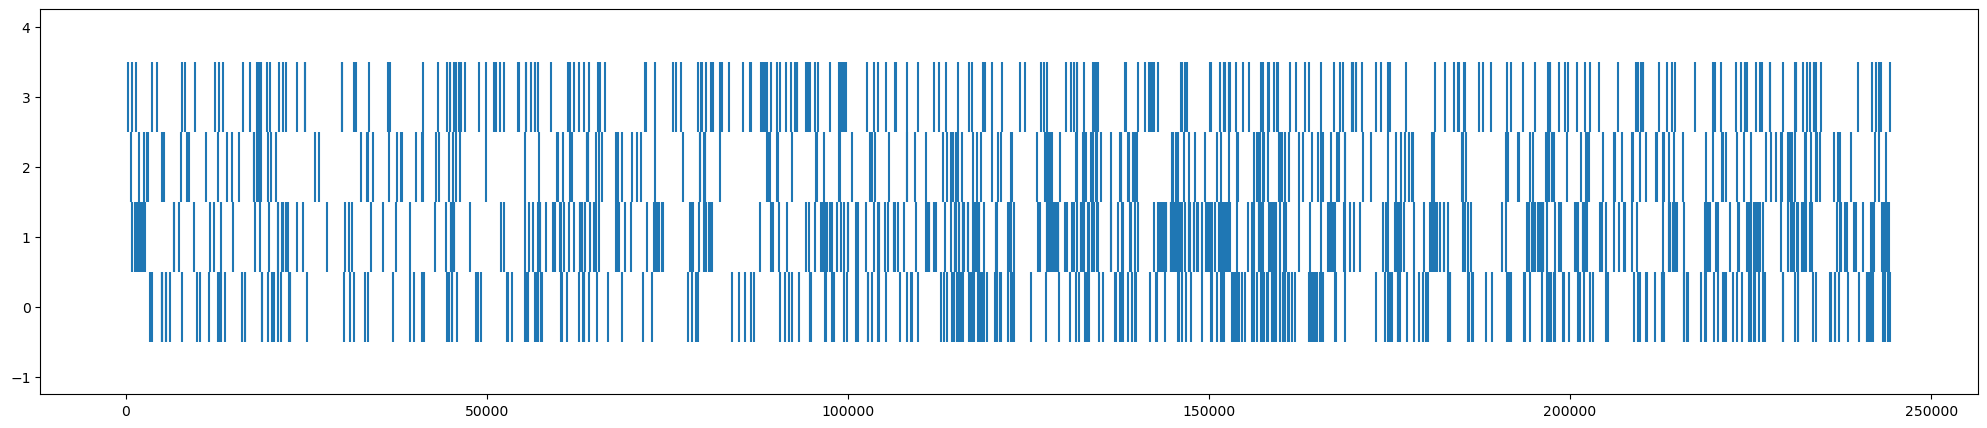

In [29]:
data = [spike_indexes[spike_labels == label] for label in unit_ids]
plt.figure(figsize=(25,5))
plt.eventplot(data)
plt.show()